# EECS 4415 - Part 6
## Exploring Big Data with Embedding Techniques

### Setup

First of all, we install the [graph2vec library](https://github.com/VHRanger/graph2vec) which offers a fast implementation of the node2vec method.

To learn how to implement fast random walks on graphs,  [read the blog post](https://www.singlelunch.com/2019/08/01/700x-faster-node2vec-models-fastest-random-walks-on-a-graph/) which explains some of the design choices behind this library.

In [46]:
!python -m pip install 'csrgraph @ git+https://github.com/VHRanger/CSRGraph@f052c1cf128ab21d21a4710337dc7c1cd5658df7'
!python -m pip install 'nodevectors @ git+https://github.com/aman0456/nodevectors@67e9af0506236be9aae6d460e96d4dec6329bcd2'

  Using cached csrgraph-0.1.29-py3-none-any.whl
  Using cached nodevectors-0.1.23-py3-none-any.whl


We now import the library, and create a small wrapper class which will expose only the few hyperparameters we will need to tune in this Colab

In [47]:
from nodevectors import Node2Vec
import networkx as nx

class Node2VecNew(Node2Vec):
  """
  Parameters
  ----------
  p : float
      p parameter of node2vec
  q : float
      q parameter of node2vec
  d : int
      dimensionality of the embedding vectors
  """
  def __init__(self, p=1, q=1, d=32):
    super().__init__(
                 n_components=d,
                     walklen=10,
                     epochs=50,
                     return_weight=1.0/p,
                     neighbor_weight=1.0/q,
                     threads=0,
                     w2vparams={'window': 4,
                                'negative': 5,
                                'iter': 10,
                                'ns_exponent': 0.5,
                                'batch_words': 128})

Lastly, let's import some of the common libraries needed for our task.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

Function to print graph information

In [50]:
def print_graph_info(G, directed=True):
  print("Number of nodes:", len(G.nodes))
  print("Number of edges:", len(G.edges))
  if directed:
    print("Average in-degree:", sum(dict(G.in_degree).values()) / len(G.nodes))
    print("Average out-degree:", sum(dict(G.out_degree).values()) / len(G.nodes))
  else:
    print("Average degree:", sum(dict(G.degree).values()) / len(G.nodes))

### Example

In the example below, we will try to reproduce the plot in the lecture notes.

In [51]:
# Load the Zachary's Karate Club as a NetworkX Graph object
KCG = nx.karate_club_graph()

# Fit embedding model to the Karate Club graph
n2v = Node2VecNew(1, 1, 2)
n2v.fit(KCG)

Making walks... Done, T=0.01
Mapping Walk Names... Done, T=0.03
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=0.30


In [52]:
embeddings = []
for node in KCG.nodes:
  embedding = list(n2v.predict(node))
  club = KCG.nodes[node]['club']
  embeddings.append(embedding + [club])

# Construct a pandas dataframe with the 2D embeddings from node2vec,
# plus the club name that each node belongs to after the split
df = pd.DataFrame(embeddings, columns=['x', 'y', 'club'])

<Axes: xlabel='x', ylabel='y'>

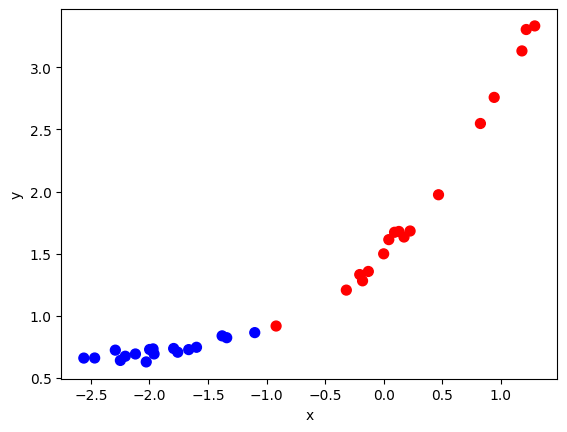

In [53]:
# Nodes who stayed with the Mr. Hi will be plotted in red, while nodes
# who moved with the Officer will be plotted in blue
colors = ['red' if x == 'Mr. Hi' else 'blue' for x in df.club]
df.plot.scatter(x='x', y='y', s=50, c=colors)

### Your Task

If our example trained correctly, you should notice a clear separation between the blue and red nodes.  Solely from the graph structure, node2vec could predict how the Zachary's Karate Club split!

Tune the hyperparameters ```p``` and ```q```, and notice how they affect the resulting embeddings.

When the Node2Vec model is trained correctly, the embeddings of Zachary’s Karate Club graph show a clear separation between the red and blue nodes, corresponding to the two groups (“Mr. Hi’s club” and the “Officer’s club”). This separation demonstrates that Node2Vec effectively captured the graph structure and predicted the split solely based on the graph’s connectivity.

Tuning the hyperparameters  p  (return parameter) and  q  (in-out parameter) significantly affects the resulting embeddings. The parameter  p  controls the likelihood of revisiting a node during random walks:

*   A higher  p  discourages revisiting nodes, promoting exploration of the graph’s broader structure, which emphasizes global relationships.
*   A lower  p  increases the focus on local neighborhoods by encouraging revisits to the same nodes.

The parameter  q  balances breadth-first search (BFS) and depth-first search (DFS) in the walks:

*   A higher  q  encourages BFS, focusing on tightly connected neighborhoods, leading to well-defined clusters of nodes.
*   A lower  q  encourages DFS, emphasizing long-range connections and global structural roles, which can reduce the clustering of local neighborhoods.

By adjusting these parameters, the embeddings can shift focus between local community structures and global relationships, influencing how well-separated or overlapping the red and blue clusters appear in the 2D embedding space.

Now we will study the behavior of node2vec on [barbell graphs](https://mathworld.wolfram.com/BarbellGraph.html).

Below you can see a toy example of a barbell graph generated with NetworkX.

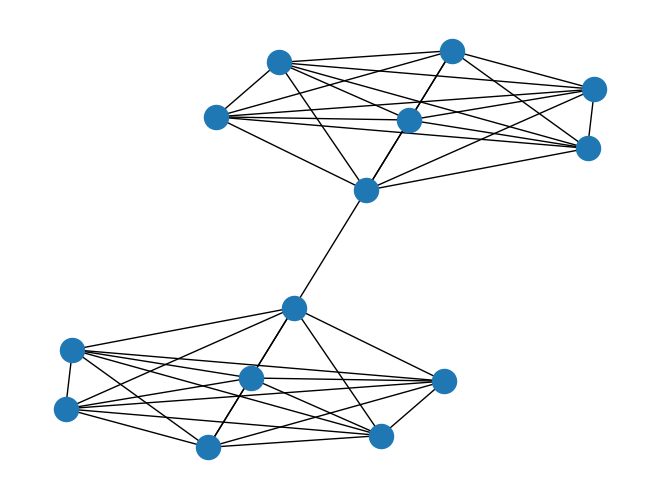

In [56]:
toy_barbell = nx.barbell_graph(7, 0)
nx.draw_kamada_kawai(toy_barbell)

Generate a larger barbell graph, where each complete graph has exactly 1000 nodes. Print graph information.

Then, learn node2vec embeddings on this graph, setting ```p = 1, q = 1``` and ```d = 10```.

In [55]:
# Generate a barbell graph with 1000 nodes in each complete graph
barbell = nx.barbell_graph(1000, 0)

print_graph_info(barbell, directed=False)

n2v = Node2VecNew(p=1, q=1, d=10)
n2v.fit(barbell)

Number of nodes: 2000
Number of edges: 999001
Average degree: 999.001
Making walks... Done, T=1.01
Mapping Walk Names... Done, T=0.93
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=46.64


Write a function that takes as input a node id ```n``` in the graph and returns a list containining the cosine similarity between the node2vec vector of the input node ```n``` and all the nodes in the given barbell graph (including the similarity with ```n``` itself).

In [57]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_cosine_similarities(n, graph, model):

    # Get the embedding of the target node `n`
    target_vector = np.array(model.predict(n)).reshape(1, -1)

    # Iterate through all nodes in the graph
    similarities = []
    for node in graph.nodes:
        # Get the embedding of the current node
        other_vector = np.array(model.predict(node)).reshape(1, -1)

        # Compute cosine similarity between `n` and the current node
        similarity = cosine_similarity(target_vector, other_vector)[0][0]
        similarities.append(similarity)

    # Return the list of similarities
    return similarities

Print the result of the function for n=5.

In [58]:
n = 5
similarities = compute_cosine_similarities(n, barbell, n2v)
print(f"Cosine similarities for node {n}: {similarities}")

Cosine similarities for node 5: [0.9301959, 0.93558216, 0.9552665, 0.95396113, 0.929624, 1.0, 0.90873694, 0.91356397, 0.9124921, 0.9270522, 0.955893, 0.97803414, 0.93089116, 0.9457448, 0.9476872, 0.9340877, 0.89277875, 0.9362558, 0.9456892, 0.89379555, 0.9454395, 0.9641656, 0.9663868, 0.93325585, 0.94031054, 0.9447041, 0.92941636, 0.89702636, 0.964904, 0.9161085, 0.9068998, 0.92320335, 0.931481, 0.93391156, 0.9755045, 0.9659221, 0.9468208, 0.9512329, 0.93750095, 0.942853, 0.9517185, 0.96661365, 0.91130894, 0.9572377, 0.98796064, 0.939432, 0.96432114, 0.93127996, 0.9449798, 0.98109746, 0.8928445, 0.9348282, 0.9690055, 0.94436926, 0.9001775, 0.94423616, 0.89645505, 0.9189555, 0.96146935, 0.9219907, 0.9231608, 0.9281704, 0.9515698, 0.95540416, 0.9618875, 0.9334758, 0.96334636, 0.9240489, 0.933989, 0.92951035, 0.8989425, 0.9706058, 0.92777276, 0.945739, 0.95000166, 0.9567394, 0.94152176, 0.91579705, 0.96530217, 0.943529, 0.89678735, 0.9337418, 0.9389083, 0.96029395, 0.9530516, 0.94792795, 

Write the function to compute the number of nodes in the graph whose embeddings have exactly 1000 neighbors with a cosine similarity greater than 0.8. Print the result.

In [59]:
from sklearn.preprocessing import normalize

def count_nodes_with_high_similarity(graph, model, similarity_threshold, neighbor_count):

    # Pre-compute embeddings for all nodes
    node_list = list(graph.nodes)
    embedding_matrix = np.array([model.predict(node) for node in node_list])
    embedding_matrix = normalize(embedding_matrix, axis=1)

    # Print embedding matrix shape and inspect the first embedding
    # print(f"Embedding matrix shape: {embedding_matrix.shape}")
    # print(f"First embedding (node {node_list[0]}): {embedding_matrix[0]}")

    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(embedding_matrix, embedding_matrix)

    # Debug: Print similarity matrix shape and inspect its first row
    # print(f"Similarity matrix shape: {similarity_matrix.shape}")
    # print(f"First row of similarity matrix: {similarity_matrix[0]}")
    # print(f"Self-similarity of first node: {similarity_matrix[0, 0]}")

    # Count nodes with required neighbors
    count = 0
    for i in range(similarity_matrix.shape[0]):
        # Get the row corresponding to the current node's similarities
        row_similarities = similarity_matrix[i]

        # Count neighbors with similarity > threshold, excluding self-similarity
        high_similarity_neighbors = np.sum(row_similarities > similarity_threshold) - 1 # Exclude self

        # Debug: Inspect high-similarity neighbors count for each node
        # print(f"Node {node_list[i]} has {high_similarity_neighbors} neighbors with similarity > {similarity_threshold}")

        # Check if the count matches the required neighbor count
        if high_similarity_neighbors == neighbor_count:
            print(f"Node {node_list[i]} satisfies the condition.")
            count += 1

    # Debug: Print the final count
    # print(f"Total nodes satisfying the condition: {count}")
    return count

result = count_nodes_with_high_similarity(barbell, n2v, similarity_threshold=0.8, neighbor_count=1000)
print(f"Number of nodes with exactly 1000 neighbors having cosine similarity > 0.8: {result}")

Number of nodes with exactly 1000 neighbors having cosine similarity > 0.8: 0


Generate another barbell graph, this time adding a path of length 51 between

---

the two complete graphs and print graph information. To find out how, refer to the NetworkX documentation: [https://networkx.github.io/documentation/stable/reference/

---

generated/networkx.generators.classic.barbell_graph.html#networkx.generators.classic.barbell_graph](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.classic.barbell_graph.html#networkx.generators.classic.barbell_graph)

Learn the node2vec embeddings for the nodes of this new graph, using the same hyperparameters as before.

In [61]:
# Generate a barbell graph with 1000 nodes in each clique and a path of length 51
barbell_with_path = nx.barbell_graph(1000, 51)
print_graph_info(barbell_with_path, directed=False)

# Learn Node2Vec embeddings using the same hyperparameters as before
n2v_with_path = Node2VecNew(p=1, q=1, d=10)
n2v_with_path.fit(barbell_with_path)

# Calculate embeddings for all nodes and store them
node_embeddings = {node: n2v_with_path.predict(node) for node in barbell_with_path.nodes}

# Debug: Print embedding for the first node as an example
print(f"Embedding for node 0: {node_embeddings[0]}")

print("Node2Vec embeddings calculated and stored for all nodes in the barbell graph with a path of length 51.")

Number of nodes: 2051
Number of edges: 999052
Average degree: 974.2096538274012
Making walks... Done, T=0.96
Mapping Walk Names... Done, T=0.92
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=27.53
Embedding for node 0: [ 0.6775577  -0.24400187 -0.6840097  -0.2041079   0.04405524  0.90734
  0.92438936 -1.1609783  -1.5293825   0.18121839]
Node2Vec embeddings calculated and stored for all nodes in the barbell graph with a path of length 51.


Print the number of nodes in the graph whose embeddings have exactly 1000 neighbors with a cosine similarity greater than 0.8.

In [62]:
print(count_nodes_with_high_similarity(barbell_with_path, n2v_with_path, similarity_threshold=0.8, neighbor_count=1000))

0


Write a function to compute the number of nodes in the graph whose embeddings have less than 100 neighbors with a cosine similarity greater than 0.8. Print the result.

In [63]:
def count_nodes_with_few_high_similarity(graph, model, similarity_threshold, max_neighbors):

    # Pre-compute embeddings for all nodes
    node_list = list(graph.nodes)
    embedding_matrix = np.array([model.predict(node) for node in node_list])
    embedding_matrix = embedding_matrix / np.linalg.norm(embedding_matrix, axis=1, keepdims=True)  # Normalize

    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(embedding_matrix, embedding_matrix)

    # Count nodes with less than max_neighbors above threshold
    count = 0
    for i in range(similarity_matrix.shape[0]):
        # Get the row corresponding to the current node's similarities
        row_similarities = similarity_matrix[i]

        # Count neighbors with similarity > threshold, excluding self-similarity
        high_similarity_neighbors = np.sum(row_similarities > similarity_threshold) - 1  # Exclude self

        # Check if the count is less than max_neighbors
        if high_similarity_neighbors < max_neighbors:
            count += 1

    return count

result = count_nodes_with_few_high_similarity(barbell_with_path, n2v_with_path, similarity_threshold=0.8, max_neighbors=100)
print(f"Number of nodes with less than 100 neighbors having cosine similarity > 0.8: {result}")

Number of nodes with less than 100 neighbors having cosine similarity > 0.8: 53


Provide analysis how changing the parameters p, q and d affect the results.

The parameters  p ,  q , and  d  in the Node2Vec model significantly influence the quality of the learned embeddings and the resulting similarity metrics. The parameter  p  controls the likelihood of revisiting the previous node during random walks. A low  p  encourages outward exploration, capturing global graph structure, while a high  p  focuses on local connectivity by revisiting nearby nodes. Adjusting  p  directly impacts the balance between global and local features in the embeddings.

Similarly,  q  determines the probability of moving closer or farther from the current node. A low  q  promotes exploration of distant nodes, capturing broader structural properties, whereas a high  q  biases the embeddings towards encoding local neighborhoods. A mismatch between  p  and  q  can lead to embeddings that overemphasize either local or global graph structures, which may reduce their utility for tasks like clustering or similarity computations.

Finally, the embedding dimensionality  d  plays a critical role in how much graph information is encoded. A low  d  may lead to underfitting, where embeddings fail to represent the graph’s complexity, resulting in poor similarity scores. On the other hand, a high  d  allows for richer representations but risks introducing noise or redundancy. The optimal choice of  d  balances representational capacity with computational efficiency, ensuring embeddings are both effective and scalable.

Write a paragraph of conclusions below summarizing your insights.

The Node2Vec parameters  p ,  q , and  d  play a crucial role in tailoring the embeddings to the graph structure and the specific analysis task. A proper balance between  p  and  q  ensures that the embeddings effectively capture both local and global graph properties. Meanwhile, choosing an appropriate dimensionality  d  is essential to avoid overfitting or underfitting. In practice, these parameters should be tuned through experimentation, guided by the graph’s topology and the downstream tasks. Understanding and adjusting these parameters can significantly enhance the quality of insights derived from node embeddings, making Node2Vec a versatile tool for graph-based learning tasks.

Once you have working code for each cell above, **head over to eClass and submit your solution for this Colab**!
